# Séparation de sources audio
Théotime le Hellard et Constantin Vaillant-Tenzer

In [1]:
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
from scipy.cluster.vq import kmeans

try:
  from torchmetrics.audio import SignalDistortionRatio
except:
  !pip install torchmetrics
  from torchmetrics.audio import SignalDistortionRatio

%matplotlib ipympl


import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.axes._axes import Axes
from matplotlib.ticker import MaxNLocator, FormatStrFormatter

from IPython.display import Audio
from scipy.io import wavfile
from scipy.signal import stft,istft


device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device :",device)

Device : cuda


<font color="red" size=6><b>Meta paramètres</b></font>

Comme calculer les spectrogrammes prend du temps, nous pouvons les calculer une fois pour toute puis les sauvegarder sur le disque. Toutefois, <font color="red"><b>ceci double l'espace occupé sur disque</b></font>: passant de 6.3 Go à 12.8 Go. Veuillez donc préciser le paramètre `SAVE_SPECTROGRAMS` selon si vous pouvez utiliser cet espace.

In [2]:
DIRECTORY = Path("source_separation")
SAVE_SPECTROGRAMS = True
USE_IPYMPL = True

# if USE_IPYMPL:
    # %matplotlib ipympl


# Chargement des signaux, Visualisation et Dataset

## Chargement des signaux et spectrogrammes

In [3]:
train_folder = DIRECTORY / "train"
train_small_folder = DIRECTORY / "train_small"
test_folder = DIRECTORY / "test"
get_path = lambda folder,i : folder / ("000"+str(i))[-4:]

datasets_sizes = {
    train_small_folder : 50,
    train_folder : 5000,
    test_folder : 2000
}

Tous les signaux ont la même fréquence d'échantillonage, même longueur; et donc les mêmes f et t échantillonés pour le Spectrogramme.

In [4]:
stft_kwargs = {
    "nperseg":400,
    "nfft":512,
    "noverlap":149 #86,
}
def check_all_same(folder=train_small_folder):
    f_ref = None
    t_ref = None
    for i in range(datasets_sizes[train_small_folder]):
        fe,signal = wavfile.read(get_path(train_small_folder,i) / "voice.wav")
        len_signal = len(signal)
        f_spec,t_spec,spec = stft(
            signal,fs=fe,**stft_kwargs)
        if f_ref is None: f_ref = f_spec ; t_ref = t_spec
        assert np.allclose(f_spec,f_ref)
        assert np.allclose(t_spec,t_ref)
    return fe,f_ref,t_ref

fe,f_ref,t_ref = check_all_same()
get_spectrogram = lambda signal : stft(signal,fs=fe,**stft_kwargs)[2]
reverse_spectrogram = lambda spec : istft(spec,fe,**stft_kwargs)[1][:80000]

# Pour vérifier que le spectrogramme est bien inversible:
def test():
    i = np.random.randint(0,datasets_sizes[train_folder])
    signal = wavfile.read(get_path(train_folder,i)/"voice.wav")[1]
    spec = get_spectrogram(signal)
    resignal = reverse_spectrogram(spec)
    print("Spectrogram shape:",spec.shape)
    print("Original signal",signal.shape)
    print("Reconstructed signal",resignal.shape)
    print("Allclose",np.allclose(signal,resignal))
test()

Spectrogram shape: (257, 320)
Original signal (80000,)
Reconstructed signal (80000,)
Allclose True


In [5]:
def torch_load(file):
    # depending on torch.__version__ you may need a 'weights_only=True' argument
    # to avoid a warning (and in old versions this kwarg doesn't exist)
    # I'm not sure since which version this warning exists,
    # so I'm doing a try/except instead of a if version>2.1: ...
    try:
        return torch.load(file,map_location=device,weights_only=True)
    except:
        return torch.load(file,map_location=device)

def load_signal_folder(folder: Path,
        load_signals=True,
        load_spectrograms=True) -> dict[str,dict]:
    """
    Return a dictionary with 3 sub dicts: "voice", "noise" and "mix"; and an "SNR" key.
    Each sub dict has 3 keys: "filename", "signal" and "spectrogram" 
    (except if load_signals or load_spectrograms are set to False)
    """
    keys = ["voice","noise","mix"]
    res = dict((k,dict()) for k in keys)
    for f in folder.iterdir():
        assert f.is_file()
        if "voice" in f.name: key = "voice"
        elif "noise" in f.name: key = "noise"
        else: 
            key = "mix"
            if f.suffix == ".wav":
                res["SNR"] = f.name.removesuffix(".wav").split("_")[-1]
        if f.suffix == ".wav" and load_signals:
            fe,signal = wavfile.read(f)
            res[key]["filename"] = f.name
            res[key]["signal"] = signal
        elif f.suffix == ".pt" and SAVE_SPECTROGRAMS and load_spectrograms: 
            # when SAVE_SPECTROGRAMS is False, we shouldn't be able to load them 
            # to save time, otherwise it's cheating.
            res[key]["spectrogram"] = torch_load(f)
    # Create missing spectrograms
    if load_spectrograms:
        for key in keys:
            if "spectrogram" not in res[key]:
                assert load_signals
                spec_abs = torch.tensor(abs(get_spectrogram(res[key]["signal"])),device=device)
                res[key]["spectrogram"] = spec_abs
                if SAVE_SPECTROGRAMS:
                    torch.save(spec_abs,folder / f"{key}_spectrogram.pt")
    return res


def remove_all_spectrograms():
    for folder in [train_folder,train_small_folder,test_folder]:
        for i in range(datasets_sizes[folder]):
            folder_i: Path = get_path(folder,i)
            for f in folder_i.iterdir():
                if "spectrogram" in f.name:
                    f.unlink()

Comme calculer les spectrogrammes prend du temps, nous pouvons les calculer une fois pour toute, en sauvegardant toutes les amplitudes des spectrogrammes sur disque (puisque l'apprentissage travaille avec les amplitudes, pas besoin de sauvegarder la phase). Attention, <font color="red"><b>ceci double l'espace occupé sur disque</b></font>: passant de 6.3 Go à 12.8 Go.
Pour les retirer utiliser: `remove_all_spectrograms()`.

In [6]:
#remove_all_spectrograms()

In [7]:
def create_spectrograms(folder: Path):
    if SAVE_SPECTROGRAMS and not (folder/"0000"/"voice_spectrogram.pt").exists():
        for i in range(datasets_sizes[folder]):
            load_signal_folder(get_path(folder,i))

create_spectrograms(train_small_folder)
create_spectrograms(test_folder)
create_spectrograms(train_folder)

In [8]:
def compute_time(folder):
    time_load_signal = 0
    time_load_spec = 0
    time_spec = 0
    start = time.perf_counter()
    for i in range(datasets_sizes[folder]):
        fe,signal = wavfile.read(get_path(folder,i) / "voice.wav")
        time_load_signal += time.perf_counter() - start ; start = time.perf_counter()
        path_spec: Path = get_path(folder,i) / "voice_spectrogram.pt"
        if path_spec.exists():
            _ = torch_load(path_spec)
        time_load_spec += time.perf_counter() - start ; start = time.perf_counter()
        _ = get_spectrogram(signal)
        time_spec += time.perf_counter() - start ; start = time.perf_counter()

    print(f"Temps total pour load {datasets_sizes[folder]} signaux: {time_load_signal}")
    print(f"Temps total pour en calculer les spectrogrammes: {time_spec}")
    print(f"Comparé au temps pour charger les spectrogrammes: {time_load_spec}")

print("Première fois:")
compute_time(test_folder)
print("\nDeuxième fois:")
compute_time(test_folder)

Première fois:
Temps total pour load 2000 signaux: 7.130788765847683
Temps total pour en calculer les spectrogrammes: 5.15103816986084
Comparé au temps pour charger les spectrogrammes: 10.755605943500996

Deuxième fois:
Temps total pour load 2000 signaux: 0.3895667716860771
Temps total pour en calculer les spectrogrammes: 2.5854648537933826
Comparé au temps pour charger les spectrogrammes: 1.4045411050319672


On voit que charger les spectrogrammes pré-calculés est plus rapide que de les calculer à chaque fois. On note aussi une grosse différence entre la première fois qu'un fichier est chargé et la seconde, j'imagine que le système place les derniers fichiers chargés dans le cache (recharger le notebook n'y change rien, donc la différence n'apparait que la toute première fois)

## Visualization

<font color="green">Note: les versions très récentes de `ipympl` ont une erreur de frappe dans le code, avec une variable nommé "buttons" au lieu de "button". Ainsi, si vous avez une version instable de `ipympl`, il se peut que d'un coup la cellule interactive ci-dessous écrivent des dizaines d'erreurs à la chaine. Nous n'avons pas trouvé ce qui les déclenche, mais vous pouvez les ignorer (puisqu'elles n'empechent pas la cellule de tourner), sinon vous pouvez simplement ouvrir le fichier d'où vient l'erreur (en cliquant sur la ligne d'erreur qui s'affiche des dizaines de fois), et changé "buttons", par "button".</font>

In [9]:
def visualize_signal(folder):
    signals = load_signal_folder(folder)
    colorbars = []
    for ax,name in zip(axs,["voice","noise","mix"]):
        spec_dB = 10*np.log10(signals[name]["spectrogram"].cpu().numpy())
        plt_obj = ax.pcolormesh(
            t_ref,f_ref,spec_dB,
            vmax=np.percentile(spec_dB,99),
            vmin=np.percentile(spec_dB,10))
        colorbars.append(plt.colorbar(plt_obj,ax=ax))
        ax.set_title(signals[name]["filename"])
        ax.tick_params(axis='both', which='major', labelsize=4)
        colorbars[-1].ax.tick_params(axis='both', which='major', labelsize=4)
        ax.set_xlabel("Temps (ms)",fontsize=4)
        ax.set_ylabel("Fréquence (GHz)",fontsize=4)
    return colorbars


folder = train_small_folder
plt.close("viz")
fig_viz = plt.figure("viz",figsize=(7,2.5))
gs = gridspec.GridSpec(2,3) # to get good control of the color bars
ax_slices = [np.s_[:,i] for i in range(3)]
axs = [fig_viz.add_subplot(gs[sli]) for sli in ax_slices]
colorbars = []

@widgets.interact(i=(0,datasets_sizes[folder]-1,1))
def update(i=1):
    for ax in axs: ax.cla()
    global colorbars
    fig_viz = plt.figure("viz")
    plt.title("")
    try: 
        if colorbars != []:
            for colorbar in colorbars:
                fig_viz.delaxes(colorbar.ax)
            gs = gridspec.GridSpec(2,3)
            for ax,sli in zip(axs,ax_slices):
                ax.set_position(gs[sli].get_position(fig_viz))
                ax.set_subplotspec(gs[sli])
    except:
        print('got an error')
        pass
    folder_i = get_path(folder,i)
    colorbars = visualize_signal(folder_i)
    fig_viz.suptitle(f"Spectogrammes pour {Path(folder_i.parent.name)/folder_i.name}")
    fig_viz.tight_layout()
    plt.show()
    


interactive(children=(IntSlider(value=1, description='i', max=49), Output()), _dom_classes=('widget-interact',…

## Dataset

In [10]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self,
            folder: Path,
            load_signals=True,
            load_spectrograms=False):
        self.folder = folder
        self.load_signals = load_signals
        self.load_spectrograms = load_spectrograms
            
    def __len__(self):
        return datasets_sizes[self.folder]
    
    def __getitem__(self,i):
        d = load_signal_folder(
            get_path(self.folder,i),
            load_signals=self.load_signals,
            load_spectrograms=self.load_spectrograms)
        ret = []
        for name in ["voice","noise","mix"]:
            if self.load_signals:
                ret.append(d[name]["signal"])
            if self.load_spectrograms:
                ret.append(d[name]["spectrogram"])
        ret.append(d["SNR"])
        return ret

Le Dataset peut contenir les signaux et/ou les spectrogrammes. De sorte à ne charger que le nécessaire. Exemple si on veut tout charger:

In [11]:
def test():
    train_dataset = MyDataset(train_folder,load_signals=True,load_spectrograms=True)
    train_dataloader = DataLoader(train_dataset,batch_size=32,shuffle=True)
    print("Dataset length:",len(train_dataset))
    for voice_signal,voice_spec,noise_signal,noise_spec,mix_signal,mix_spec,snr in train_dataloader:
        print("Signal's shape: ",voice_signal.shape)
        print("Spectrogram's shape: ",voice_spec.shape)
        print("SNRs :",snr)
        break

test()

Dataset length: 5000
Signal's shape:  torch.Size([32, 80000])
Spectrogram's shape:  torch.Size([32, 257, 320])
SNRs : ('4', '3', '-1', '0', '-2', '1', '4', '-2', '3', '-2', '-1', '0', '0', '-2', '-4', '1', '1', '0', '0', '3', '-1', '0', '-2', '1', '-1', '-4', '1', '-3', '2', '2', '4', '-2')


# Seq2Seq using a U-Net: Singing Voice Separation With Deep U-Net Convolutional Networks

D'après le [papier de A. Jansson et al](https://openaccess.city.ac.uk/id/eprint/19289/1/7bb8d1600fba70dd79408775cd0c37a4ff62.pdf)

Et pour [l'architecture](https://github.com/phillipi/pix2pix/blob/master/models.lua) (qui vient du papier [Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/pdf/1611.07004))

<font color="green"><b>Remarque / Astuce</b></font>:
Le réseau UNet divise la matrice par des puissances de 2, ici $2^6=64$, puis remultiplie d'autant. Ainsi, pour garder la même dimension en sortie, il est nécessaire que la dimension de la matrice d'entrée soit un multiple de 64. C'est pourquoi pour calculer les spectrogrammes nous prenons un `noverlap=149` (et non 100 comme indiqué dans le cours), ce qui donne $320 = 64*5$ temps d'échantillon (la 2nd dimension). (`noverlap=86` donne $256$ mais n'est pas toujours inversible...). Concernant la 1ère dimension, elle est à $257$: nous oublierons la dernière valeur (ce qui ramène à $256 = 64 * 4$), et en sortie le masque prend la même valeur en fréquence 257 qu'en fréquence 256, pas idéal...

In [12]:
def change_dim_257_to_256(x):
    return x[...,:256,:]

def change_dim_256_to_257(y):
    return torch.cat([y,y[...,-1,:].unsqueeze(-2)],-2)

In [13]:
class OurUNet(torch.nn.Module):
    def __init__(self,n_levels=5):
        super().__init__()
        self.n_levels = n_levels
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.drop_out = nn.Dropout(0.5)
        ngf = 16
        nb_C = [ngf*2**i for i in range(n_levels+1)]

        # Partie Descendante
        self.down_convs = nn.ModuleList()
        self.down_norms = nn.ModuleList()
        self.first_conv = nn.Conv2d(1,ngf,5,2,2)
        for i in range(n_levels):
            self.down_convs.append(nn.Conv2d(
                in_channels=nb_C[i],
                out_channels=nb_C[i+1],
                kernel_size=(5,5),
                stride=2,
                padding=5//2,
            ))
            if i < n_levels-1:
                self.down_norms.append(nn.BatchNorm2d(nb_C[i+1]))

        # Partie Ascendante
        self.up_convs = nn.ModuleList()
        self.up_norms = nn.ModuleList()
        self.last_conv = nn.ConvTranspose2d(2*ngf,1,5,2,5//2,output_padding=1)
        for i in range(n_levels,0,-1):
            self.up_convs.append(nn.ConvTranspose2d(
                in_channels=2*nb_C[i] if i<n_levels else nb_C[i],
                out_channels=nb_C[i-1],
                kernel_size=(5,5),
                stride=2,
                padding=5//2,
                output_padding=1
            ))
            self.up_norms.append(nn.BatchNorm2d(nb_C[i-1]))



    def forward(self,spec: torch.Tensor,print_shapes=False):
        # Preprocess:
        if len(spec.shape)==2:
            has_batch_dim = False
            spec = spec.unsqueeze(0)
        else:
            has_batch_dim = True
        mask = change_dim_257_to_256(spec) # => Shape (B,256,320)
        mask = mask.unsqueeze(1) # => Shape (B,1,256,320)
        if print_shapes: print(mask.shape)

        # Partie Descendante
        mask = self.first_conv(mask)
        stack = [mask]
        if print_shapes: print(mask.shape)
        for i in range(self.n_levels):
            mask = self.leaky_relu(mask)
            mask = self.down_convs[i](mask)
            if i < self.n_levels-1:
                mask = self.down_norms[i](mask)
                stack.append(mask)
            if print_shapes: print(mask.shape)

        if print_shapes: print("-")
        # Partie Ascendante
        for i in range(self.n_levels,0,-1):
            if i < self.n_levels:
                mask = torch.cat([mask,stack.pop()],dim=1)
            mask = torch.relu(mask)
            mask = self.up_convs[self.n_levels-i](mask)
            mask = self.up_norms[self.n_levels-i](mask)
            if self.n_levels-i < 3:
                mask = self.drop_out(mask)
            if print_shapes: print(mask.shape)
        mask = torch.cat([mask,stack.pop()],dim=1)
        mask = torch.relu(mask)
        mask = self.last_conv(mask)
        if print_shapes: print(mask.shape)

        # Postprocess:
        mask = mask.squeeze(1) # => Shape (B,256,320)
        mask = torch.nn.functional.sigmoid(mask)
        mask = change_dim_256_to_257(mask) # => Shape (B,257,320)
        if not has_batch_dim:
            mask = mask.squeeze(0)
        if print_shapes: print("Output shape:",mask.shape)
        return mask

In [14]:
def test():
    model = OurUNet().to(device)
    train_dataset = MyDataset(train_folder,load_signals=False,load_spectrograms=True)
    train_dataloader = DataLoader(train_dataset,batch_size=32,shuffle=True)
    for voice_spec,noise_spec,mix_spec,snr in train_dataloader:
        mask = model(voice_spec.to(device),print_shapes=True)
        break
test()

torch.Size([32, 1, 256, 320])
torch.Size([32, 16, 128, 160])
torch.Size([32, 32, 64, 80])
torch.Size([32, 64, 32, 40])
torch.Size([32, 128, 16, 20])
torch.Size([32, 256, 8, 10])
torch.Size([32, 512, 4, 5])
-
torch.Size([32, 256, 8, 10])
torch.Size([32, 128, 16, 20])
torch.Size([32, 64, 32, 40])
torch.Size([32, 32, 64, 80])
torch.Size([32, 16, 128, 160])
torch.Size([32, 1, 256, 320])
Output shape: torch.Size([32, 257, 320])


/home/cvaillanttenzer/.conda/envs/torch_env/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


<font color="Green"><b>Remarque</b></font>
Le papier original utilise un Modèle par source, donc ici ce serait 1 pour la voix et 1 pour le bruit, dans l'idée de pouvoir étendre à plus de sources. Pour limiter le temps d'entrainement (ne pas le doubler), nous n'utilisons ici qu'un seul modèle: le masque prédit sert à retrouver la voix, et (1-masque) donne le bruit. La fonction de perte s'applique sur les 2 signaux. 

In [15]:
def source_separation(model: OurUNet,mix_signal):
    # Use the trained model to process the mixed signal
    mix_spec = get_spectrogram(mix_signal)
    mix_spec_abs = abs(torch.tensor(mix_spec).to(device))
    mix_spec_phase = np.angle(mix_spec)
    with torch.no_grad():
        mask = model(mix_spec_abs)
    # Voice:
    voice_spec_abs = mask * mix_spec_abs
    voice_spec = voice_spec_abs.cpu().numpy() * np.exp(1j*mix_spec_phase)
    voice_signal = reverse_spectrogram(voice_spec)
    # Noise:
    noise_spec_abs = (1-mask) * mix_spec_abs
    noise_spec = noise_spec_abs.cpu().numpy() * np.exp(1j*mix_spec_phase)
    noise_signal = reverse_spectrogram(noise_spec)
    return voice_spec_abs,voice_signal,noise_spec_abs,noise_signal,mask
    
SDR = SignalDistortionRatio().to(device)
def NSDR(pred_S,ref_S,mix_S):
    pred_S = torch.tensor(pred_S).to(device)
    ref_S = torch.tensor(ref_S).to(device)
    mix_S = torch.tensor(mix_S).to(device)
    return SDR(pred_S,ref_S) - SDR(mix_S,ref_S)


def evaluate(model: OurUNet,
        folder_valid,
        loss_fn=torch.nn.L1Loss()):
    model.eval()
    with torch.no_grad():
        losses = [] ; nsdrs = []
        for i in range(datasets_sizes[folder_valid]):
            dir = load_signal_folder(get_path(folder_valid,i),load_signals=True,load_spectrograms=True)
            mix_signal = dir["mix"]["signal"]
            pred_voice_spec_abs,pred_voice_signal,pred_noise_spec_abs,pred_noise_signal,_ = source_separation(model,mix_signal)
            losses.append(
                loss_fn(pred_voice_spec_abs,dir["voice"]["spectrogram"])
                + loss_fn(pred_noise_spec_abs,dir["noise"]["spectrogram"]))
            nsdrs.append(
                NSDR(pred_voice_signal,dir["voice"]["signal"],mix_signal)
                + NSDR(pred_noise_signal,dir["noise"]["signal"],mix_signal))
        loss = torch.mean(torch.Tensor(losses))
        nsdr = torch.mean(torch.Tensor(nsdrs))
    model.train()
    return loss,nsdr



def train(
        model:nn.Module,
        n_epochs:int,
        dataloader_train:DataLoader,
        folder_valid:DataLoader,
        save_path:Path,
        loss_fn=torch.nn.L1Loss(),
        adam_lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(),lr=adam_lr)
    losses = []
    losses_valid, nsdrs_valid = [], []
    torch.cuda.empty_cache()
    for _ in tqdm(range(n_epochs),desc="Training epochs"):
        model.train()
        current_losses = []
        for voice_spec,noise_spec,mix_spec,snr in dataloader_train:
            voice_spec = voice_spec.to(device)
            noise_spec = noise_spec.to(device)
            mix_spec = mix_spec.to(device)
            optimizer.zero_grad()
            mask = model(mix_spec)
            pred_voice_spec = mask * mix_spec
            pred_noise_spec = (1-mask) * mix_spec
            loss = (loss_fn(pred_voice_spec,voice_spec)
                + loss_fn(pred_noise_spec,noise_spec))
            current_losses.append(loss.item())
            loss.backward()
            optimizer.step()
        losses.append(torch.Tensor(current_losses).mean().item())
        # Validation à chaque epoch:
        loss_valid,nsdr_valid = evaluate(model,folder_valid,loss_fn)
        losses_valid.append(loss_valid)
        nsdrs_valid.append(nsdr_valid)

    # Métriques
    performances = {
        "training_losses" : losses,
        "validation_losses" : losses_valid,
        "validation_nsdrs" : nsdrs_valid,
        "n_epochs" : n_epochs
    }
    # Pour sauvegarder les données:
    if not save_path.exists():
        save_path.mkdir()
    torch.save(model, save_path/"model.pt")
    torch.save(losses, save_path/"training_losses.pt")
    torch.save(losses_valid, save_path/"validation_losses.pt")
    torch.save(nsdrs_valid, save_path/"validation_nsdrs.pt")
    return model, performances



In [16]:
def plot_perfs(perfs:dict,save_path:Path):
    plt.close("viz")
    fig = plt.figure(figsize=(7,3))
    axs = fig.subplots(1,3)
    ax_loss: Axes = axs[0]
    ax_valid_loss: Axes = axs[1]
    ax_valid_nsdr: Axes = axs[2]
    name = save_path.name.removeprefix("save_")
    fig.suptitle(f"Performances du model : {name}")

    losses = perfs["training_losses"]
    arange = np.linspace(perfs["n_epochs"],0,len(losses),endpoint=False)[::-1]
    # Training loss:
    ax_loss.plot(arange,losses)
    ax_loss.set_title("Training Loss")
    ax_loss.yaxis.set_major_formatter(FormatStrFormatter("%.3f"))
    ax_loss.tick_params(axis="y",labelsize=6,labelrotation=90)
    ax_loss.locator_params(nbins=4)
    ax_loss.set_xlabel("Epoch")
    ax_loss.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Validation loss:
    ax_valid_loss.plot(arange,perfs["validation_losses"])
    ax_valid_loss.set_title("Validation Loss")
    ax_valid_loss.yaxis.set_major_formatter(FormatStrFormatter("%.3f"))
    ax_valid_loss.tick_params(axis="y",labelsize=6,labelrotation=90)
    ax_valid_loss.locator_params(nbins=4)
    ax_valid_loss.set_xlabel("Epoch")
    ax_valid_loss.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Validation NSDR
    ax_valid_nsdr.plot(arange,perfs["validation_nsdrs"])
    ax_valid_nsdr.set_title("Validation NSDR")
    # ax_valid_nsdr.set_ylim([0,1])
    ax_valid_nsdr.set_xlabel("Epoch")
    ax_valid_nsdr.xaxis.set_major_locator(MaxNLocator(integer=True))

    fig.tight_layout()

    plt.savefig(save_path/"performances.png")
    plt.show()

In [17]:
save_path = Path("./save_unet")
train_dataset = MyDataset(
    train_folder,
    load_signals=False,
    load_spectrograms=True)
train_dataloader = DataLoader(train_dataset,batch_size=32,shuffle=True)


unet_model = OurUNet().to(device)
unet_model,perfs = train(
    unet_model,
    120,
    dataloader_train=train_dataloader,
    folder_valid=train_small_folder,
    save_path=save_path
)

'\nunet_model = OurUNet().to(device)\nunet_model,perfs = train(\n    unet_model,\n    120,\n    dataloader_train=train_dataloader,\n    folder_valid=train_small_folder,\n    save_path=save_path\n)'

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

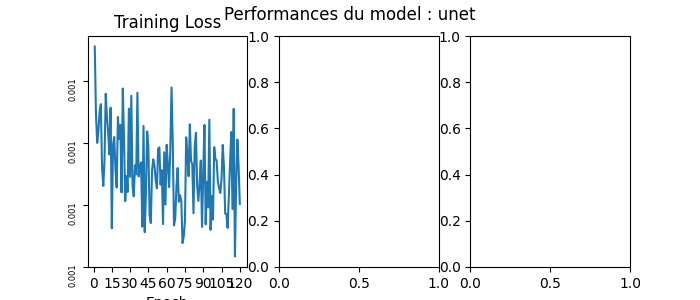

In [25]:
perfs = {
    "training_losses" : torch_load(save_path/"training_losses.pt"),
    "validation_losses" : torch_load(save_path/"validation_losses.pt"),
    "validation_nsdrs" : torch_load(save_path/"validation_nsdrs.pt"),
    "n_epochs" : 120
}

plot_perfs(perfs,save_path=save_path)

## Evaluation

### Solution Naive

Une solution naive pour séparer du bruit de la parole: avoir un masque qui vaut 1 sur les "grosse" valeur du spectre, et 0 ailleurs. Pour définir "grosse valeur", nous utilisons un kmeans avec 2 points sur l'ensemble des valeurs prises par le spectrogramme.

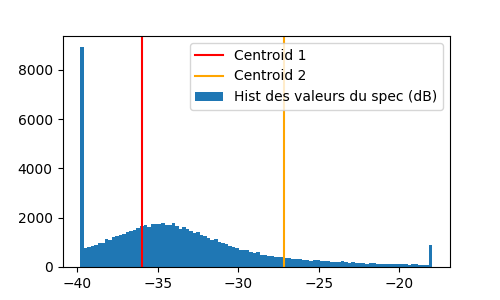

In [26]:
plt.close()
plt.figure("Hist spectrogram values",figsize=(5,3))
example_dir = load_signal_folder(get_path(train_small_folder,1))
example_mix_signal = example_dir["mix"]["signal"]
example_spec_dB = 10*np.log10(abs(get_spectrogram(example_mix_signal))).flatten()
vmax = np.percentile(example_spec_dB,99)
vmin = np.percentile(example_spec_dB,10)
example_spec_dB = np.clip(example_spec_dB,vmin,vmax)
pts, _ = kmeans(example_spec_dB.flatten(),2)
plt.axvline(min(pts),color="red",label="Centroid 1")
plt.axvline(max(pts),color="orange",label="Centroid 2")
plt.hist(example_spec_dB,100,range=[vmin,vmax],label="Hist des valeurs du spec (dB)")
plt.legend()
plt.show()

In [27]:
def dummy_model(spec):
    # Un masque qui vaut 1 si on a une "grosse" valeur, 0 sinon
    spec_dB = torch.log10(spec).to(device)
    pts, _ = kmeans(spec_dB.cpu().numpy().flatten(),2)
    pt1 = float(min(pts)) ; pt2 = float(max(pts))
    return (abs(spec_dB - pt1) > abs(spec_dB - pt2)).to(int)*0.999+0.0001

tested_model = dummy_model

In [28]:
def display_audios(tested_model):
    folder = train_small_folder
    @widgets.interact(i=(0,datasets_sizes[folder]-1,1))
    def update(i=1):
        dir = load_signal_folder(get_path(folder,i),load_signals=True,load_spectrograms=False)
        mix_signal = dir["mix"]["signal"]
        make_label = lambda label : widgets.HTML(value=f"<b>{label}</b>")
        make_audio = lambda signal : Audio(data=signal.T,rate=fe)
        _,pred_voice_signal,_,pred_noise_signal,_ = source_separation(tested_model,mix_signal)
        display(make_label("Mix Signal:"))
        display(make_audio(mix_signal))
        display(make_label("Original voice:"))
        display(make_audio(dir["voice"]["signal"]))
        display(make_label("Reconstructed voice:"))
        display(make_audio(pred_voice_signal))
        display(make_label("Original noise:"))
        display(make_audio(dir["noise"]["signal"]))
        display(make_label("Reconstructed noise:"))
        display(make_audio(pred_noise_signal))

display_audios(tested_model)

interactive(children=(IntSlider(value=1, description='i', max=49), Output()), _dom_classes=('widget-interact',…

In [29]:
example_mask = None

def widget_spectrograms(tested_model):
    def visualize_signal_and_reconstructed(folder):
        dir = load_signal_folder(folder)
        colorbars = []
        for ax,name in zip(original_axs,["mix","voice","noise"]):
            spec_dB = 10*np.log10(dir[name]["spectrogram"].cpu().numpy())
            plt_obj = ax.pcolormesh(
                t_ref,f_ref,spec_dB,
                vmax=np.percentile(spec_dB,99),
                vmin=np.percentile(spec_dB,10))
            colorbars.append(plt.colorbar(plt_obj,ax=ax))
            ax.set_title(dir[name]["filename"])
            ax.tick_params(axis='both', which='major', labelsize=4)
            colorbars[-1].ax.tick_params(axis='both', which='major', labelsize=4)
            ax.set_xlabel("Temps (ms)",fontsize=4)
            ax.set_ylabel("Fréquence (GHz)",fontsize=4)


        mix_signal = dir["mix"]["signal"]
        voice_spec_abs,_,noise_spec_abs,_,mask = source_separation(tested_model,mix_signal)
        global example_mask
        example_mask = mask
        for ax,spec,name in zip(
                res_axs,
                [mask,voice_spec_abs,noise_spec_abs],
                ["Mask","Reconstructed Voice","Reconstructed Noise"]):
            if spec is mask:
                spec_dB = spec.cpu().numpy()
                kwargs = {}
            else:
                spec_dB = 10*np.log10(spec.cpu().numpy())
                kwargs = {
                    "vmax":np.percentile(spec_dB,99),
                    "vmin":np.percentile(spec_dB,10)}
            plt_obj = ax.pcolormesh(
                t_ref,f_ref,spec_dB,**kwargs)
            colorbars.append(plt.colorbar(plt_obj,ax=ax))
            ax.set_title(name)
            ax.tick_params(axis='both', which='major', labelsize=4)
            colorbars[-1].ax.tick_params(axis='both', which='major', labelsize=4)
            ax.set_xlabel("Temps (ms)",fontsize=4)
            ax.set_ylabel("Fréquence (GHz)",fontsize=4)
        return colorbars


    folder = train_small_folder
    plt.close("viz")
    fig_viz = plt.figure("viz",figsize=(7,5))
    gs = gridspec.GridSpec(4,3) # to get good control of the color bars
    original_slices = [np.s_[:2,i] for i in range(3)]
    res_slices = [np.s_[2:,i] for i in range(3)]
    ax_slices = original_slices + res_slices

    original_axs = [fig_viz.add_subplot(gs[sli]) for sli in original_slices]
    res_axs = [fig_viz.add_subplot(gs[sli]) for sli in res_slices]
    axs = original_axs + res_axs

    colorbars = []

    @widgets.interact(i=(0,datasets_sizes[folder]-1,1))
    def update(i=1):
        for ax in axs: ax.cla()
        nonlocal colorbars
        fig_viz = plt.figure("viz")
        plt.title("")
        try: 
            if colorbars != []:
                for colorbar in colorbars:
                    fig_viz.delaxes(colorbar.ax)
                gs = gridspec.GridSpec(4,3)
                for ax,sli in zip(axs,ax_slices):
                    ax.set_position(gs[sli].get_position(fig_viz))
                    ax.set_subplotspec(gs[sli])
        except Exception as e:
            print('got an error')
            print(e)
            pass
        folder_i = get_path(folder,i)
        colorbars = visualize_signal_and_reconstructed(folder_i)
        fig_viz.suptitle(f"Spectogrammes pour {Path(folder_i.parent.name)/folder_i.name}")
        fig_viz.tight_layout()
        plt.show()
        
widget_spectrograms(tested_model)

interactive(children=(IntSlider(value=1, description='i', max=49), Output()), _dom_classes=('widget-interact',…

### Le UNet entrainé

In [30]:
save_path = Path("./save_unet")
unet_model = torch_load(save_path/"model.pt")

def tanh(x):
    return (torch.tanh(x)+1)/2

#unet_model = torch_load(save_path/"big_model.pt")
unet_model.eval()
tested_model = unet_model

In [31]:
display_audios(tested_model)

interactive(children=(IntSlider(value=1, description='i', max=49), Output()), _dom_classes=('widget-interact',…

In [32]:
widget_spectrograms(tested_model)

interactive(children=(IntSlider(value=1, description='i', max=49), Output()), _dom_classes=('widget-interact',…

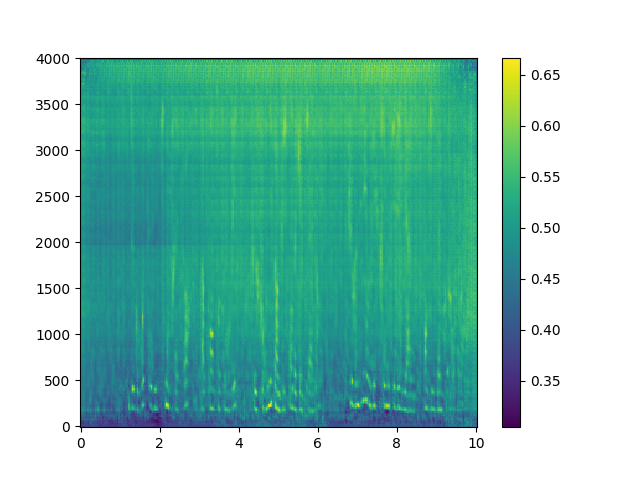

No such comm: 1657dfbbeb2a454caf748e9a0cf6b3dd


In [33]:
plt.close()
plt.figure("Small test mask")
plt.pcolormesh(t_ref, f_ref, example_mask.cpu().numpy())
plt.colorbar()
# plt.colorbar(plt_obj)
plt.show()

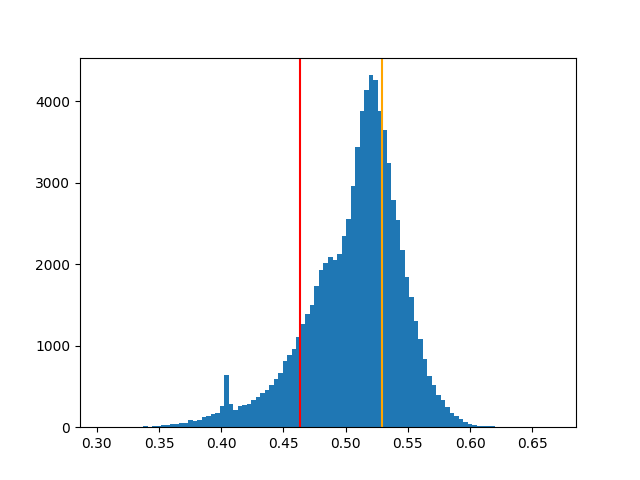

In [35]:
plt.close()
plt.figure("hist mask")
example_mask_numpy = example_mask.cpu().numpy().flatten()
pts, _ = kmeans(example_mask_numpy,2)
plt.axvline(min(pts),color="red",label="Centroid 1")
plt.axvline(max(pts),color="orange",label="Centroid 2")
plt.hist(example_mask_numpy,100)
plt.show()

In [36]:
def keep_high_vals(spec):
    mask = unet_model(torch.tensor(spec,device=device))
    mask_numpy = mask.cpu().numpy().flatten()
    pts, _ = kmeans(mask_numpy,2)
    high = float(max(pts))
    return (mask > high).to(int)
    
tested_model = keep_high_vals

In [37]:
display_audios(tested_model)

interactive(children=(IntSlider(value=1, description='i', max=49), Output()), _dom_classes=('widget-interact',…

In [38]:
widget_spectrograms(tested_model)

interactive(children=(IntSlider(value=1, description='i', max=49), Output()), _dom_classes=('widget-interact',…

# Conv-tasnet: surpassing ideal time–frequency magnitude masking for speech separation.
(Inspired from Luo et al., 2019 and from this popular Github repository : https://github.com/JusperLee/Conv-TasNet/tree/master/Conv_TasNet_Pytorch)

In [255]:
batch_size = 4

train_dataset = MyDataset(
    train_folder,
    load_signals=True,
    load_spectrograms=False)
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

print("Dataset length:",len(train_dataset))

Dataset length: 5000


In [256]:
for voice_signal,noise_signal,mix_signal,snr in train_dataloader:
    print("Spec's shape:",voice_signal.shape)
    print("SNRs:",snr)
    break

Spec's shape: torch.Size([4, 80000])
SNRs: ('-4', '0', '-3', '0')


In [257]:
def count_n_param(model):
    return sum([p.numel() for p in model.parameters()])

In [258]:
class ConvTasNet(nn.Module):
    def __init__(self, 
                 num_sources=2, 
                 num_filters=512, 
                 kernel_size=16, 
                 stride=8, 
                 bottleneck_channels=128, 
                 num_blocks=8, 
                 num_repeats=3):
        super(ConvTasNet, self).__init__()

        # Encoder
        #self.encoder = nn.Conv1d(batch_size, num_filters, kernel_size, stride, padding=kernel_size//2, bias=False)
        self.encoder = nn.Conv1d(1, num_filters, kernel_size, stride, padding=kernel_size//2, bias=False)

        # Separator
        self.separator = TemporalConvNet(num_filters, 
                                         bottleneck_channels, 
                                         num_blocks, 
                                         num_repeats, 
                                         num_sources)

        # Decoder
        self.decoder = nn.ConvTranspose1d(num_filters, 1, kernel_size, stride, padding=kernel_size//2, bias=False)


    def forward(self, mixture, print_shapes=False):
        """
        Args:
            mixture (torch.Tensor): Mixture audio signal, shape (batch, 1, time).

        Returns:
            torch.Tensor: Separated audio signals, shape (batch, num_sources, time).
        """
        # Encoder
        encoded = nn.functional.relu(self.encoder(mixture))

        # Separator
        masks = self.separator(encoded)
        if print_shapes: print(masks.shape)

        # Apply masks
        
        # Make encode.shape: torch.Size([32, 2, 512, 10001])
        encoded_unsqueeze = encoded.unsqueeze(1)

        sources = masks * encoded_unsqueeze

        # Decoder
        decoded_sources = torch.cat([
            self.decoder(sources[:, i]).unsqueeze(1)
            for i in range(sources.size(1))
        ], dim=1)

        if print_shapes: print(decoded_sources.shape)

        return masks, decoded_sources


class TemporalConvNet(nn.Module):
    def __init__(self, 
                 num_filters, 
                 bottleneck_channels, 
                 num_blocks, 
                 num_repeats, 
                 num_sources):
        super(TemporalConvNet, self).__init__()

        self.layers = nn.ModuleList()
        for r in range(num_repeats):
            for b in range(num_blocks):
                dilation = 2 ** b
                self.layers.append(TemporalBlock(num_filters, bottleneck_channels, dilation))

        self.mask_generator = nn.Conv1d(num_filters, num_filters * num_sources, kernel_size=1)
        self.num_sources = num_sources
        self.num_filters = num_filters

    def forward(self, x, print_shapes=False):
        """
        Args:
            x (torch.Tensor): Encoded mixture, shape (batch, num_filters, time).

        Returns:
            torch.Tensor: Masks for each source, shape (batch, num_sources, num_filters, time).
        """
        for layer in self.layers:
            x = layer(x)
            if print_shapes: print(x.shape)

        if print_shapes: print("-")
        masks = self.mask_generator(x)  # shape (batch, num_filters * num_sources, time)
        masks = masks.view(masks.size(0), self.num_sources, self.num_filters, masks.size(2))  # shape (batch, num_sources, num_filters, time)
        masks = nn.functional.softmax(masks, dim=1)  # Normalize across sources
        if print_shapes: print("mask_shape:", masks.shape)

        return masks


class TemporalBlock(nn.Module):
    def __init__(self, num_filters, bottleneck_channels, dilation):
        super(TemporalBlock, self).__init__()

        dilation = int(dilation)

        self.layer_norm = nn.LayerNorm(num_filters)
        self.conv1x1 = nn.Conv1d(num_filters, bottleneck_channels, kernel_size=1, bias=False)
        
        self.depthwise_conv = nn.Conv1d(
            bottleneck_channels, 
            bottleneck_channels, 
            kernel_size=3, 
            stride=1, 
            padding=dilation, 
            dilation=(dilation,), 
            groups=bottleneck_channels, 
            bias=False
        )

        self.pointwise_conv = nn.Conv1d(bottleneck_channels, num_filters, kernel_size=1, bias=False)
        self.relu = nn.ReLU()

    def forward(self, x, print_shapes=False):
        """
        Args:
        x (torch.Tensor): Input tensor, shape (batch, num_filters, time).
        
        Returns:
        torch.Tensor: Output tensor, shape (batch, num_filters, time).
        """
        residual = x
        x = x.transpose(1, 2)
        x = self.layer_norm(x)
        x = x.transpose(1, 2)
        x = self.relu(self.conv1x1(x))
        x = self.relu(self.depthwise_conv(x))
        x = self.pointwise_conv(x)
        
        if print_shapes: print(x.shape)
                
        return x + residual

In [259]:
model = ConvTasNet(
    num_sources=2, 
    num_filters=256,  
    bottleneck_channels=64,  
    num_blocks=4,  
    num_repeats=2  
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)
print("nombre de paramètres:", count_n_param(model))

# Clear GPU cache
torch.cuda.empty_cache()
if mix_signal.shape[1] != 1:
    mix_signal = mix_signal.unsqueeze(1)  # Adds a channel dimension if missing

print("Mix signal shape:", mix_signal.shape)

voice_signal, mix_signal = voice_signal.to(device), mix_signal.to(device)

mask, output = model(mix_signal,print_shapes=True)


ConvTasNet(
  (encoder): Conv1d(1, 256, kernel_size=(16,), stride=(8,), padding=(8,), bias=False)
  (separator): TemporalConvNet(
    (layers): ModuleList(
      (0): TemporalBlock(
        (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (conv1x1): Conv1d(256, 64, kernel_size=(1,), stride=(1,), bias=False)
        (depthwise_conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), groups=64, bias=False)
        (pointwise_conv): Conv1d(64, 256, kernel_size=(1,), stride=(1,), bias=False)
        (relu): ReLU()
      )
      (1): TemporalBlock(
        (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (conv1x1): Conv1d(256, 64, kernel_size=(1,), stride=(1,), bias=False)
        (depthwise_conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), groups=64, bias=False)
        (pointwise_conv): Conv1d(64, 256, kernel_size=(1,), stride=(1,), bias=False)
        (relu): ReLU()
      )
      (2): Temporal

RuntimeError: CUDA out of memory. Tried to allocate 40.00 MiB (GPU 0; 23.69 GiB total capacity; 13.08 GiB already allocated; 20.62 MiB free; 13.14 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [260]:
# Evaluation function
def evaluate_model(model, dataloader, criterion, device):
    """
    Evaluate the model on the given dataloader.
    
    Args:
        model (torch.nn.Module): The trained model.
        dataloader (DataLoader): DataLoader for the validation/test dataset.
        criterion (torch.nn.Module): Loss function.
        device (torch.device): Device to use for computation.
    
    Returns:
        float: Average loss over the dataset.
    """

    with torch.no_grad():
        for batch in dataloader:
            # Load data
            voice_signal, noise_signal, mix_signal, snr = batch
            
            # Convert mix_signal to mono-channel if needed
            mixture = mix_signal.unsqueeze(1).to(device)  # Shape: [batch, 1, time]
            
            # Stack voice and noise signals as sources
            sources = torch.stack([voice_signal, noise_signal], dim=1).to(device)  # Shape: [batch, num_sources, time]
            
            # Forward pass
            predicted_sources = model(mixture)
            
            # Compute loss
            loss = criterion(predicted_sources, sources)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss


In [261]:
# Test dataloader
test_dataset = MyDataset(test_folder, load_signals=False, load_spectrograms=True)
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [ ]:
# Training loop
num_epochs = 10
learning_rate = 0.001
num_sources = 2

# Initialize model, loss function, and optimizer
model = ConvTasNet(num_sources=num_sources, num_filters=256, kernel_size=3, stride=8, bottleneck_channels=64, num_blocks=8, num_repeats=3)
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.to(device) # Move model to the GPU

train_losses = []
validation_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")
    
    # Iterate over batches
    for batch in progress_bar:
        # Load data
        voice_signal, noise_signal, mix_signal, snr = batch
        if mix_signal.shape[1] != 1:
            mix_signal = mix_signal.unsqueeze(1)  # Adds a channel dimension if missing
        voice_signal, noise_signal, mix_signal = voice_signal.to(device), noise_signal.to(device), mix_signal.to(device)

        # Forward pass
        mask, output = model(mix_signal)

        #print(mask.shape) #torch.Size([32, 2, 256, 10001])
        #print(mix_signal.shape) #torch.Size([32, 1, 80000])

        # Resize the mask to match the mix_signal dimensions
        mask = mask.view(mask.size(0), mask.size(1), -1)
        mask = mask[:, :, :mix_signal.size(2)]

        pred_voice_signal = mask[:, 0, :] * mix_signal.squeeze(1)
        pred_noise_signal = mask[:, 1, :] * mix_signal.squeeze(1)

        # Compute loss
        loss = (loss_fn(pred_voice_signal, voice_signal)
                + loss_fn(pred_noise_signal, noise_signal))
            
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
        
    # Save the train loss for this epoch
    print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {epoch_loss / len(train_dataloader):.4f}")
    train_losses.append(epoch_loss / len(train_dataloader))

    # Validation phase
    val_loss = evaluate_model(model, test_dataloader, loss_fn, device)
    validation_losses.append(val_loss)
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Loss: {val_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), "conv_tasnet.pth")
print("Training complete! Model saved as 'conv_tasnet.pth'.")

Epoch 1/10:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 1/10:  52%|█████▏    | 644/1250 [14:58<13:49,  1.37s/it, loss=0.0328]

In [ ]:
# Tracé de la loss au cours des epochs
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

### Avec la loss SI-SPR
Il s'agit de la loss proposée dans l'article de Luo et Mesgarani

In [192]:
# Definition de la SI-SDR loss


def si_sdr_loss(estimated_sources, reference_sources):
        """
        Args:
            estimated_sources (torch.Tensor): Tensor of shape (batch, num_sources, time).
            reference_sources (torch.Tensor): Tensor of shape (batch, num_sources, time).
        
        Returns:
            torch.Tensor: SI-SDR loss.
        """
        # Compute the dot product between the estimated sources and the reference sources
        dot = torch.sum(estimated_sources * reference_sources, dim=-1, keepdim=True)  # shape: (batch, num_sources, 1)
        
        # Compute the energy of the reference sources
        energy_reference = torch.sum(reference_sources ** 2, dim=-1, keepdim=True)  # shape: (batch, num_sources, 1)
        
        # Compute the optimal scaling factor
        optimal_scaling = dot / energy_reference  # shape: (batch, num_sources, 1)
        
        # Compute the projection of the estimated sources on the reference sources
        projected = optimal_scaling * reference_sources  # shape: (batch, num_sources, time)
        
        # Compute the error
        error = estimated_sources - projected
        
        # Compute the SI-SDR loss
        si_sdr = -10 * torch.log10(torch.sum(projected ** 2, dim=-1) / torch.sum(error ** 2, dim=-1))
        
        # Return the SI-SDR loss
        return torch.mean(si_sdr)

In [ ]:
# Training loop
num_epochs = 10
learning_rate = 0.001
num_sources = 2

# Initialize model, loss function, and optimizer
model = ConvTasNet(num_sources=num_sources, num_filters=256, kernel_size=16, stride=8, bottleneck_channels=128, num_blocks=8, num_repeats=3)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.to(device) # Move model to the GPU

train_losses = []
validation_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")
    
    # Iterate over batches
    for batch in progress_bar:
        # Load data
        voice_signal, noise_signal, mix_signal, snr = batch
        voice_signal, noise_signal, mix_signal = voice_signal.to(device), noise_signal.to(device), mix_signal.to(device)

        # Forward pass
        mask, output = model(mix_signal)

        # Resize the mask into [32, 8000]
        # On enelève les dernier nombre du mask pour avoir torch.Size([32, 2, 256, 10000]) ou lieu de torch.Size([32, 2, 256, 10001])
        mask_for_loss = mask[:,:,:,:-1]
        # On resize le mask pour avoir torch.Size([2, 32, 80000]) en fusionnant le deux derniers dimensions
        mask_for_loss = mask_for_loss.permute(1,0,2,3).reshape(2,32,80000)

        
        pred_voice_signal = mask_for_loss * mix_signal
        pred_noise_signal = (1 - mask_for_loss) * mix_signal

        # Compute loss
        loss = (si_sdr_loss(pred_voice_signal,voice_signal)
                + si_sdr_loss(pred_noise_signal,noise_signal))
            
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
        
    # Save the train loss for this epoch
    print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {epoch_loss / len(train_dataloader):.4f}")
    train_losses.append(epoch_loss / len(train_dataloader))

    # Validation phase
    val_loss = evaluate_model(model, test_dataloader, loss_fn, device)
    validation_losses.append(val_loss)
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Loss: {val_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), "conv_tasnet_sdr.pth")
print("Training complete! Model saved as 'conv_tasnet_sdr.pth'.")

Epoch 1/10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/10:  99%|█████████▉| 156/157 [03:24<00:01,  1.31s/it, loss=0.0322]


RuntimeError: Given groups=1, weight of size [256, 32, 16], expected input[1, 8, 80000] to have 32 channels, but got 8 channels instead

In [ ]:
# Tracé de la loss au cours des epochs
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

### Evaluation

In [ ]:
def display_audios(tested_model):
    folder = train_small_folder
    @widgets.interact(i=(0,datasets_sizes[folder]-1,1))
    def update(i=1):
        dir = load_signal_folder(get_path(folder,i),load_signals=True,load_spectrograms=False)
        mix_signal = dir["mix"]["signal"]
        make_label = lambda label : widgets.HTML(value=f"<b>{label}</b>")
        make_audio = lambda signal : Audio(data=signal.T,rate=fe)
        _,pred_voice_signal,_,pred_noise_signal,_ = source_separation(tested_model,mix_signal)
        display(make_label("Mix Signal:"))
        display(make_audio(mix_signal))
        display(make_label("Original voice:"))
        display(make_audio(dir["voice"]["signal"]))
        display(make_label("Reconstructed voice:"))
        display(make_audio(pred_voice_signal))
        display(make_label("Original noise:"))
        display(make_audio(dir["noise"]["signal"]))
        display(make_label("Reconstructed noise:"))
        display(make_audio(pred_noise_signal))

interactive(children=(IntSlider(value=1, description='i', max=49), Output()), _dom_classes=('widget-interact',…

In [ ]:
example_mask = None

def widget_spectrograms(tested_model):
    def visualize_signal_and_reconstructed(folder):
        dir = load_signal_folder(folder)
        colorbars = []
        for ax,name in zip(original_axs,["mix","voice","noise"]):
            spec_dB = 10*np.log10(dir[name]["spectrogram"].cpu().numpy())
            plt_obj = ax.pcolormesh(
                t_ref,f_ref,spec_dB,
                vmax=np.percentile(spec_dB,99),
                vmin=np.percentile(spec_dB,10))
            colorbars.append(plt.colorbar(plt_obj,ax=ax))
            ax.set_title(dir[name]["filename"])
            ax.tick_params(axis='both', which='major', labelsize=4)
            colorbars[-1].ax.tick_params(axis='both', which='major', labelsize=4)
            ax.set_xlabel("Temps (ms)",fontsize=4)
            ax.set_ylabel("Fréquence (GHz)",fontsize=4)


        mix_signal = dir["mix"]["signal"]
        voice_spec_abs,_,noise_spec_abs,_,mask = source_separation(tested_model,mix_signal)
        global example_mask
        example_mask = mask
        for ax,spec,name in zip(
                res_axs,
                [mask,voice_spec_abs,noise_spec_abs],
                ["Mask","Reconstructed Voice","Reconstructed Noise"]):
            if spec is mask:
                spec_dB = spec.cpu().numpy()
                kwargs = {}
            else:
                spec_dB = 10*np.log10(spec.cpu().numpy())
                kwargs = {
                    "vmax":np.percentile(spec_dB,99),
                    "vmin":np.percentile(spec_dB,10)}
            plt_obj = ax.pcolormesh(
                t_ref,f_ref,spec_dB,**kwargs)
            colorbars.append(plt.colorbar(plt_obj,ax=ax))
            ax.set_title(name)
            ax.tick_params(axis='both', which='major', labelsize=4)
            colorbars[-1].ax.tick_params(axis='both', which='major', labelsize=4)
            ax.set_xlabel("Temps (ms)",fontsize=4)
            ax.set_ylabel("Fréquence (GHz)",fontsize=4)
        return colorbars


    folder = train_small_folder
    plt.close("viz")
    fig_viz = plt.figure("viz",figsize=(7,5))
    gs = gridspec.GridSpec(4,3) # to get good control of the color bars
    original_slices = [np.s_[:2,i] for i in range(3)]
    res_slices = [np.s_[2:,i] for i in range(3)]
    ax_slices = original_slices + res_slices

    original_axs = [fig_viz.add_subplot(gs[sli]) for sli in original_slices]
    res_axs = [fig_viz.add_subplot(gs[sli]) for sli in res_slices]
    axs = original_axs + res_axs

    colorbars = []

    @widgets.interact(i=(0,datasets_sizes[folder]-1,1))
    def update(i=1):
        for ax in axs: ax.cla()
        nonlocal colorbars
        fig_viz = plt.figure("viz")
        plt.title("")
        try: 
            if colorbars != []:
                for colorbar in colorbars:
                    fig_viz.delaxes(colorbar.ax)
                gs = gridspec.GridSpec(4,3)
                for ax,sli in zip(axs,ax_slices):
                    ax.set_position(gs[sli].get_position(fig_viz))
                    ax.set_subplotspec(gs[sli])
        except Exception as e:
            print('got an error')
            print(e)
            pass
        folder_i = get_path(folder,i)
        colorbars = visualize_signal_and_reconstructed(folder_i)
        fig_viz.suptitle(f"Spectogrammes pour {Path(folder_i.parent.name)/folder_i.name}")
        fig_viz.tight_layout()
        plt.show()

interactive(children=(IntSlider(value=1, description='i', max=49), Output()), _dom_classes=('widget-interact',…

### Le UNet entrainé

In [ ]:
save_path = Path("./save_conv_tasnet")
conv_model = torch_load(save_path/"model.pt")

def tanh(x):
    return (torch.tanh(x)+1)/2

conv_model.eval()
tested_model = conv_model

In [ ]:
display_audios(tested_model)

interactive(children=(IntSlider(value=1, description='i', max=49), Output()), _dom_classes=('widget-interact',…

In [ ]:
widget_spectrograms(tested_model)

interactive(children=(IntSlider(value=1, description='i', max=49), Output()), _dom_classes=('widget-interact',…

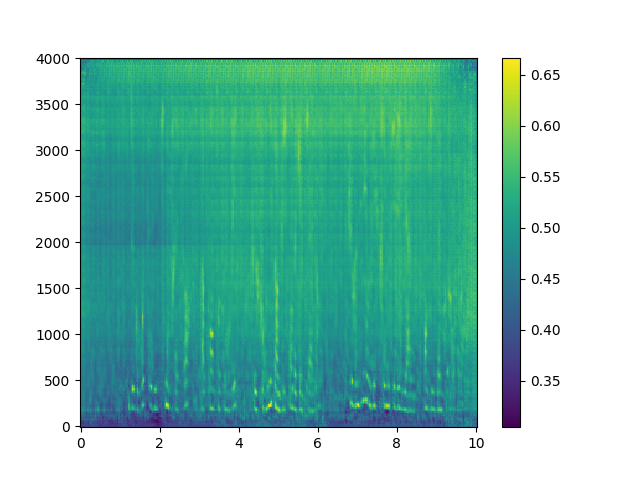

No such comm: 1657dfbbeb2a454caf748e9a0cf6b3dd


In [ ]:
plt.close()
plt.figure("Small test mask")
plt.pcolormesh(t_ref, f_ref, example_mask.cpu().numpy())
plt.colorbar()
# plt.colorbar(plt_obj)
plt.show()

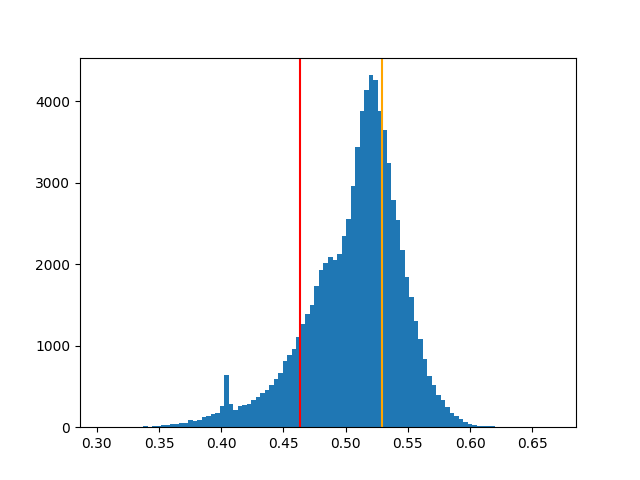

In [ ]:
plt.close()
plt.figure("hist mask")
example_mask_numpy = example_mask.cpu().numpy().flatten()
pts, _ = kmeans(example_mask_numpy,2)
plt.axvline(min(pts),color="red",label="Centroid 1")
plt.axvline(max(pts),color="orange",label="Centroid 2")
plt.hist(example_mask_numpy,100)
plt.show()